In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pandas import Series, DataFrame
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df=pd.read_csv('ClothingStore2020.csv', low_memory=False)

# <font color='blue'>Introduction</font>

In this assignment, you are acting as analysts for a retail clothing store chain. The <tt>ClothingStore</tt> data set represents actual data provided by a clothing store chain in New England (taken from dataminingconsultant.com).<BR>
Our data mining task is a classification problem. You are to classify which customers will respond to a direct-mail marketing promotion, based on information collected about the customers.<BR>
You become more familiar with the data set using EDA, graphical and descriptive statistical methods for learning about data.

# <font color='blue'>Getting a feel for the data set</font>

In [3]:
df.RESP.value_counts().sort_index()/len(df.RESP)

0    0.834647
1    0.165353
Name: RESP, dtype: float64

The target variable will be <font color='blue'>RESP</font>. As can be seen above, the overall proportion of responders to the direct-mail marketing promotion is 16.54%.

# Question 1
One of the variable, <font color='blue'>CLUSTYPE</font>, contains the market segmentation category for each customer as defined by Nielsen Claritas.

- (a) Generate a table that contains the top 5 cluster type with the highest frequencies (so most prevalent lifestyle cluster type).
- (b) Match the cluster type in the file *Lifestyle.htm* and report the labels. Hint: use ``pd.read_html('Lifestyle.htm')`` to load the htm-file and use a ``merge`` from Chapter 8 of McKinney's book *Python for Data Analysis*
- (c) Give a description of the clientele with the highest frequencies (determined in 1(a)) in terms of income and education.
- (d) Calculate the response rate per cluster type. Show the five cluster types that have the highest response rate.

Here is an example of the first row of the table generated by 1(b):

| Count | Nr | Label | Characteristics |
| ----- | -- | ----- | --------------- |
| 3488  | 10 | Home Sweet Home | These households are typically married couples... |

In [4]:
#1a. top 5 of cluster type
freq = df.CLUSTYPE.value_counts(sort=True).head(5).to_frame().rename(columns={'CLUSTYPE': 'Count'})
freq

,Count
10,3488
1,2716
4,2284
16,1893
8,1430


In [5]:
#1b. matching cluster type via merge
keys = pd.read_html('Lifestyle.htm')[0]
keys = keys.set_index(keys['Nr']).drop(columns=['Nr'])
keys.head()

,Label,Characteristics
Nr,,
1,Upper Crust,These are families with older children located...
2,Lap of Luxury,"These are family homeowners, with children, li..."
3,Established Wealth,These are families with and without children. ...
4,Mid-Life Success,These are households with very high incomes li...
5,Prosperous Metro Mix,These are typically married couples with young...


In [6]:
mergedDf = freq.merge(keys, left_index=True, right_index=True)
mergedDf

,Count,Label,Characteristics
10,3488,Home Sweet Home,These households are typically married couples...
1,2716,Upper Crust,These are families with older children located...
4,2284,Mid-Life Success,These are households with very high incomes li...
16,1893,Country Home Families,These are typically married families with chil...
8,1430,Movers and Shakers,These are typically households containing sing...


In [7]:
#1c. description of clientele from selection
print('The description of the selected groups are the following:')
for i in mergedDf.Characteristics:
    print(f'* {i}')

The description of the selected groups are the following:
* These households are typically married couples with one or no children at home. They have an above average household income, own their home and are primarily concentrated in the suburbs.
* These are families with older children located in the suburbs. They have very high levels of income and education and work in executive, managerial and other professional occupations.
* These are households with very high incomes living in suburban areas. They are homeowners with very high property values, primarily working in white-collar occupations such as sales.
* These are typically married families with children, located in rural areas. They have a household income very near the national average, own their home and work in blue-collar occupations
* These are typically households containing singles and couples, with two workers and no children. They live in the suburbs and some urban areas and have high levels of education and income.


Based on these descriptions of the top 5 cluster types, these clientele contain high income/high education families, except for Country Home Families.

In [8]:
#1d. response rate per cluster
dfx = df.merge(keys, left_on = 'CLUSTYPE', right_on = 'Nr')
pd.pivot_table(dfx, index = ['Label'], values = ['RESP'] ,aggfunc='mean').nlargest(5,'RESP')

,RESP
Label,
Anomalies,0.277778
Country Classics,0.230769
Established Wealth,0.197572
Lap of Luxury,0.196319
Domestic Duos,0.185714


# <font color='blue'>Negative Amounts Spent?</font>

# Question 2
For the amounts-spent  and proportions-spent fields, some of the customers have negative values for the amount or proportion of money spent. How can this be? Now, the data were collected within a particular time period, which is unspecified, perhaps a month or a quarter. It is possible for a customer to have bought some clothing in a prior period, and returned the purchased clothing in the time period from which the data are collected. If this customer also did not make any major purchases during the time period of interest, then the net sales for this customer would be negative.
- (a) For the variable <font color='blue'>PSSPEND</font> (amount spend at the PS franchise), determine the number customers with a negative amount spent.
- (b) Generate a flag variable that recodes <font color='blue'>PSSPEND</font> in 'Neg','Pos' and 'Zero'.
- (c) Using this flag variable generate a crosstab showing the marketing response *rate* for the three spending  categories 'Neg','Pos' and 'Zero'.
- (d) In the remainder of this assignment, we consider the absolute value of spending observations. Motivate why this is a reasonable choice given the results of 2(c).

In [9]:
#2a. counting negative PSSPEND
print("Negatives lines in the dataset, assuming that every line is a customer: ",df['PSSPEND'][df.PSSPEND <0].count())

Negatives lines in the dataset, assuming that every line is a customer:  102


In [10]:
#2b. creating flag variable
def flag(value_in):
    if value_in < 0: value_out = "Neg"
    elif value_in > 0: value_out = "Pos"
    elif value_in == 0: value_out = "Zero"
    return value_out
df['PSSPEND_FLAG'] = [flag(x) for x in df['PSSPEND']]

In [11]:
#2c. response rate based on the flag variable
pd.pivot_table(df, index = ['PSSPEND_FLAG'], values = ['RESP'] ,aggfunc='mean')

,RESP
PSSPEND_FLAG,
Neg,0.215686
Pos,0.221943
Zero,0.119837


#2d. The response rate is almost the same for Positive and Negative values. Therefore, we could consider the absolute value of spending observations for the remainder of the assignment.

# <font color='blue'>Transformations to Achieve Normality or Symmetry</font>

# Question 3
Most of the numeric fields are right-skewed. For example, the column <font color='blue'>HI</font> contains a variable which takes large values for customers who purchase only a few different classes of clothes (e.g., blouses, legwear, pants), and small values for customers who purchase many different classes of clothes (hence giving an indication of the product uniformity).
- (a) Generate a histogram of <font color='blue'>HI</font> using 50 bins (Hint: what is the data type of <font color='blue'>HI</font>?). Do you see some spikes? Is there a pattern?

Many data mining methods and models function best when the variables are normally distributed, or,
at least when they are symmetric. The analyst may choose transformations such as the natural log (<tt>np.log</tt>) transformation or the square root transformation (<tt>np.sqrt</tt>).
- (b) Transform <font color='blue'>HI</font> in <font color='blue'>HI_log</font> using the log transformation and generate again a histogram. Compare the skewness of <font color='blue'>HI</font> and <font color='blue'>HI_log</font> using the <tt>DataFrame</tt>.**skew** method.
- (c) The column <font color='blue'>PBLOUSES</font> contains information about the percentage spent on blouses. This could be negative, so first define <font color='blue'>PBLOUSES_abs</font> as the absolute value of <font color='blue'>PBLOUSES</font>. Which transformation do you suggest to achieve more symmetry: the log of square root transformation? Motivate your answer.

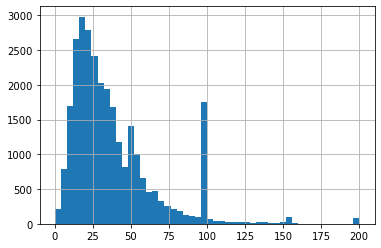

In [12]:
#3a. histogram of HI
#converting object to numeric, suppressing errors as we want to get the overall view
df['HI_float'] = pd.to_numeric(df['HI'], errors='coerce') 
df['HI_float'].hist(bins=50)

We observe multiple spikes in the right tail, just around 50, 100, 150 and 200.

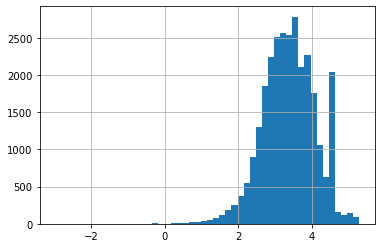

In [13]:
#3b. log transformation to 'normalize' the distribution
df['HI_LOG'] = np.log(df['HI_float'])
df['HI_LOG'].hist(bins=50)

In [14]:
print("Skewness of HI: ", df['HI_float'].skew())
print("Skewness of HI_log: ", df['HI_LOG'].skew())

Skewness of HI:  1.760008108909455
Skewness of HI_log:  -0.2997313544284717


After the log transformation, the skewness is reduced.

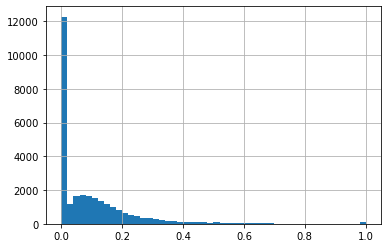

In [15]:
#3c. percentage spent on blouses
#absolute PBLOUSES
df['PBLOUSES_abs'] = np.abs(df['PBLOUSES'])
df['PBLOUSES_abs'].hist(bins=50)

There are a spike of zero values that have to be taken out for the subsequent analysis.

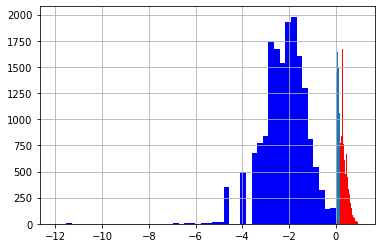

In [16]:
#filter zero values out as they are irrelevant
df['PBLOUSES_nonzeros'] = df['PBLOUSES_abs'][df['PBLOUSES_abs'] !=0] 

#log and sqrt transformation
df['PBLOUSES_nonzeros_log'] = np.log(df['PBLOUSES_nonzeros']) 
df['PBLOUSES_nonzeros_sqrt'] = np.sqrt(df['PBLOUSES_nonzeros'])

#visually comparing the log and squareroot
df['PBLOUSES_nonzeros'].hist(bins=50)
df['PBLOUSES_nonzeros_log'].hist(bins=50, color='b') #as PBLOUSES is proportion taken absolute, it shows negative values
df['PBLOUSES_nonzeros_sqrt'].hist(bins=50, color='r') #when showed alone, it shows quite nice normalized

C:\Users\simon\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\simon\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


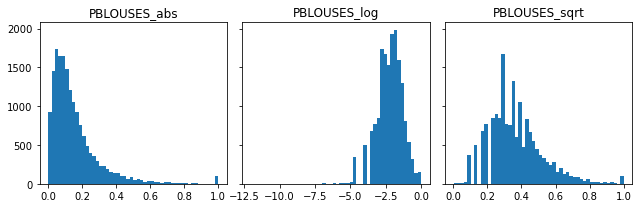

In [17]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(9,3))
axs[0].hist(df["PBLOUSES_nonzeros"], bins=50)
axs[1].hist(df["PBLOUSES_nonzeros_log"], bins=50)
axs[2].hist(df["PBLOUSES_nonzeros_sqrt"], bins=50)
axs[0].title.set_text('PBLOUSES_abs')
axs[1].title.set_text('PBLOUSES_log')
axs[2].title.set_text('PBLOUSES_sqrt')
plt.show();

In [18]:
#comparing skewness
print("Skewness of abs: ", df['PBLOUSES_nonzeros'].skew())
print("Skewness of log: ", df['PBLOUSES_nonzeros_log'].skew())
print("Skewness of sqrt: ", df['PBLOUSES_nonzeros_sqrt'].skew())

Skewness of abs:  2.443046566069417
Skewness of log:  -0.98471712914725
Skewness of sqrt:  0.946873370025104


The square root transformation has less skewness than log (albeit not by much).

# <font color='blue'>Exploring the relationship between the predictors and the response</font>

# Question 4
We would like to investigate the variable-by-variable association between the predictors and the target variable, response to the marketing promotion.
Below your can find transformations of the following variables:

- <font color='blue'>FRE</font>: the number of purchase visits
- <font color='blue'>PBLOUSES</font>: the percentage spent on blouses
- <font color='blue'>HI</font>: index about product uniformity

Based on the nonnormalized and normalized histograms (you may use the code below and change the ``varname``), describe for each of the above transformed variables the relationship with the target variable.

In [19]:
def hist_norm(column,bins):
    global df
    x0=df[column][df.RESP==0] #overlay dimension
    x1=df[column][df.RESP==1] #overlay dimension
    plt.figure(figsize=(12,5))
    (n, bin_limits, _) = plt.hist([x1,x0], bins=bins,stacked=True,color=['#ff7f0e','#1f77b4']);
    with np.errstate(divide='ignore',invalid='ignore'):
        n_norm = n / n.sum(axis=0)
    labels=np.round((bin_limits[1:]+bin_limits[:-1])/2,1)    # determine middle of classes
    response=pd.DataFrame({'1':n_norm[0,:],'0':n_norm[1,:]},index=labels)
    response.plot.bar(stacked=True,figsize=(12,5), color=['#ff7f0e','#1f77b4'])

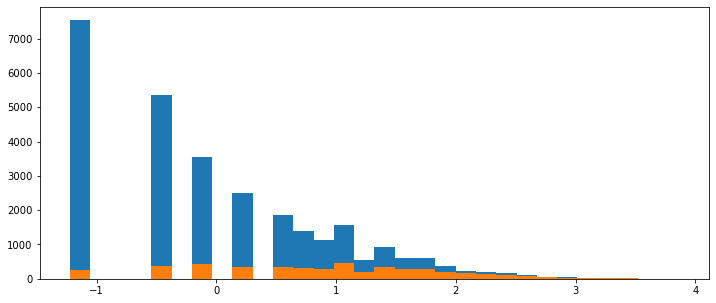

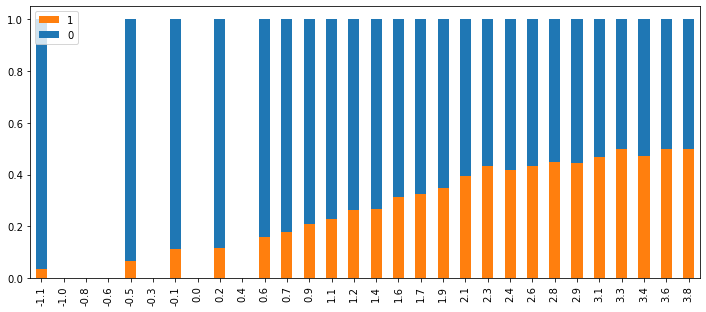

In [20]:
df['FRE_log_z']=stats.zscore(np.log(df.FRE), ddof=1)
hist_norm('FRE_log_z',30)

The number of purchase visits is positively correlated with target variable.

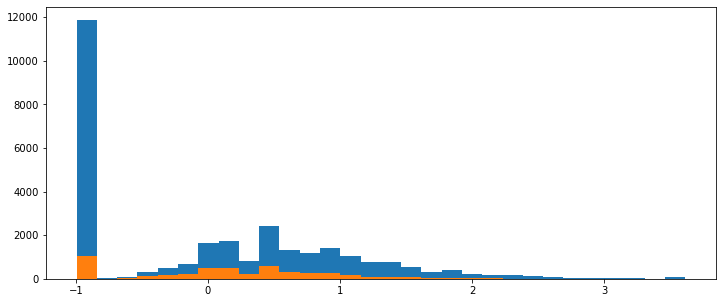

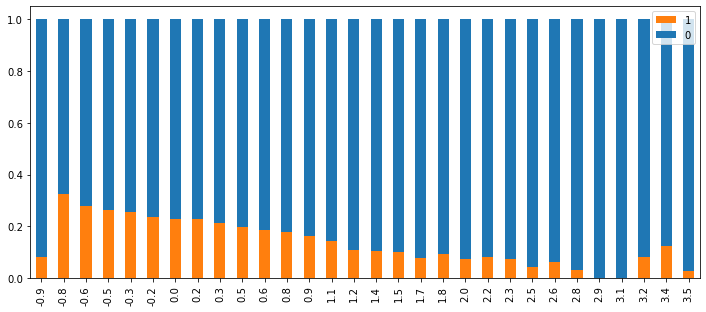

In [21]:
df['PBLOUSES_abs_sqrt_z']=stats.zscore(np.sqrt(np.abs(df.PBLOUSES)), ddof=1)
hist_norm('PBLOUSES_abs_sqrt_z',30)

The percentage spent on blouses is negatively correlated with target variable.

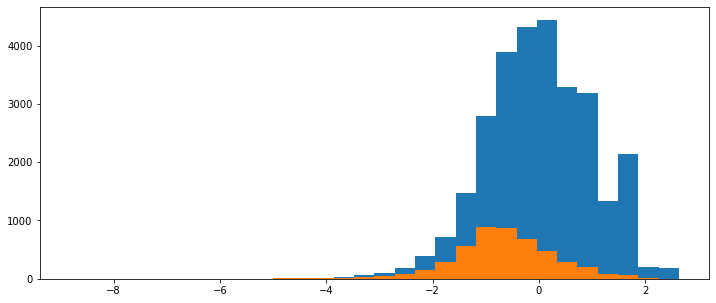

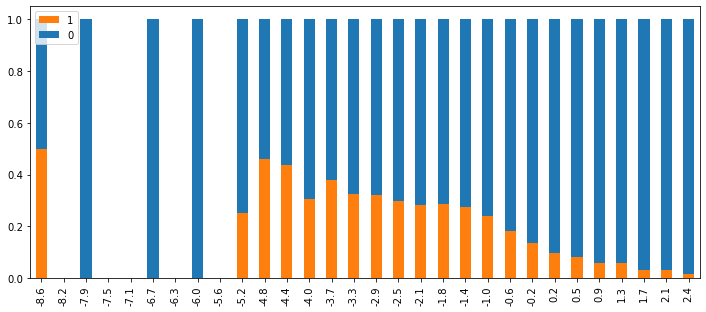

In [22]:
df['HI_float'] = pd.to_numeric(df['HI'], errors='coerce') 
df['HI_log']=np.log(df['HI_float'])
df['HI_log_z']=stats.zscore(df['HI_log'], ddof=1,nan_policy='omit') #omitting errors because of missing values
hist_norm('HI_log_z',30)

The index about product uniformity is negatively correlated with target variable.

# Question 5
Next, we would like to investigate the relationship with indicator variables and the response rate. 
Consider the flag variables:

- <font color='blue'>WEB</font>: equals 1 for those who have made purchases via the company’s web shopping option
- <font color='blue'>CC_CARD</font>: equals 1 for credit card holder

Please, answer the following three questions:
- (a) Using normalized bar chart with the *response* overlay, describe for each of the above variables the relationship with the target variable.
- (b) Using crosstabs determine how many times Web buyers are more likely to respond to those have not made a purchase via the Web. Repeat for credit card holders versus noncredit card holders.
- (c) Using <tt>stats.chi2_contingency()</tt> test if the relationship between <font color='blue'>WEB</font> and <font color='blue'>RESP</font> is significant at a 5% nominal significance level. State hypotheses, observed test statistic, p-value, decision and conclusion.

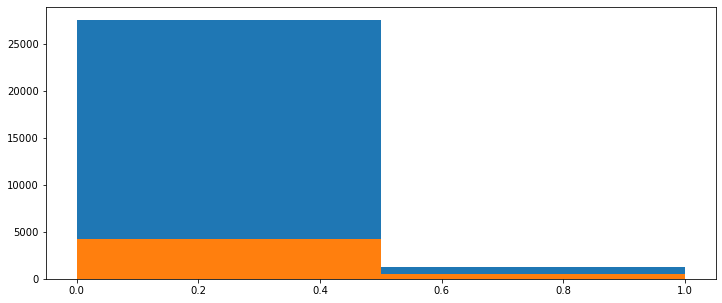

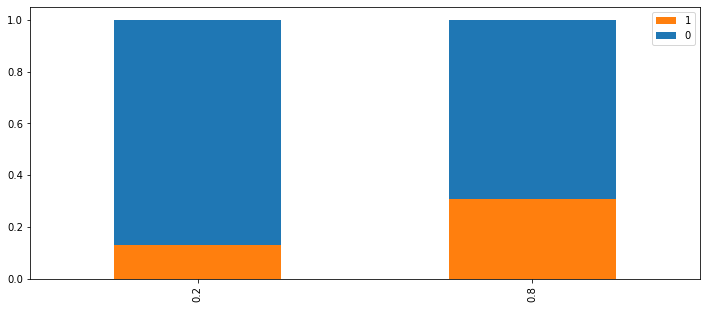

In [23]:
#5a. response overlay for WEB, second is normalized
hist_norm('WEB',2)

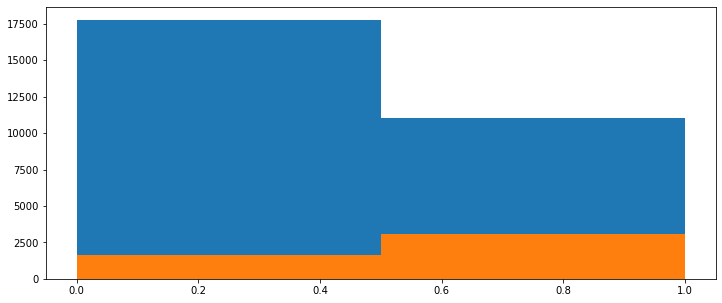

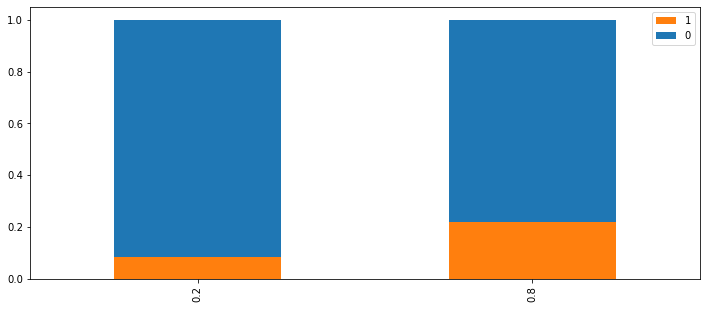

In [24]:
#for CC_CAR, second is normalized
hist_norm('CC_CARD',2)

In [25]:
#5b. crosstab
r = df['RESP']
p = df['WEB']
crosstab = pd.crosstab(r, p, normalize='columns')
crosstab
print('Web users are more likely to respond than non-web users by: ', \
      (crosstab[1][1]/crosstab[0][1]).round(2), " times")

r = df['RESP']
p = df['CC_CARD']
crosstab = pd.crosstab(r, p, normalize='columns')
crosstab
print('Credit card users are more likely to respond than non-credit card users by: ', \
      (crosstab[1][1]/crosstab[0][1]).round(2), " times")

WEB,0,1
RESP,,
0,0.847528,0.551476
1,0.152472,0.448524


Web users are more likely to respond than non-web users by:  2.94  times


CC_CARD,0,1
RESP,,
0,0.906236,0.719336
1,0.093764,0.280664


Credit card users are more likely to respond than non-credit card users by:  2.99  times


In [26]:
#5c. significance test between RESP and WEB
CT =pd.crosstab(df['WEB']==1,df['RESP']==1)
print(CT)

from scipy.stats import chi2_contingency
chi2, p, dof, expected =stats.chi2_contingency((CT))
print (f'Chi-square Statistic : {chi2}, p-value: {p}')

RESP   False  True 
WEB                
False  23346   4200
True     691    562
Chi-square Statistic : 758.973274321165, p-value: 4.4905961996028165e-167


H0: There is no relationship between WEB and RESP

H1: There is a relationship between WEB and RESP

Based on the observed value of 758.97 and an extremely small p-value, we reject H0 and conclude that there is a statistically significant relationship between WEB and RESP at 5% siginificance level.